<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#AB-Testing" data-toc-modified-id="AB-Testing-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>AB-Testing</a></span></li></ul></div>

# AB-Testing

![cats](images/cats.jpeg)


Imaginad que somos los cientificos de datos de la empresa de videojuegos Tactile Entertainment. Los desarrolladores del juego Cookie Cats pretenden introducir un cambio en el juego para aumentar la retencion de los jugadores. En cierto nivel del juego los jugadores se encuentran una puerta que les obliga a esperar o a pagar la app. Actualmente la puerta se encuentra en nivel 30 y se pretende pasar al nivel 40, para comprobar la retencion a 1 y 7 dias. Antes de realizar el cambio definitivo en el juego se raliza un test AB.

Los datos estan alojados en `data/cookie_cats.csv`. Nuestro grupo de control sera la version actual `gate_30` y el grupo de tratamiento sera la version `gate_40`. Debemos realizar el test para 1 dia de retencion `retention_1` y para 7 dias `retention_7`.

In [92]:
# librerias

import pandas as pd
import numpy as np

from statsmodels.stats.proportion import proportions_ztest, proportion_confint
from scipy.stats import norm, sem

import pylab as plt

import statsmodels.stats.api as sms
from scipy.stats import bernoulli, beta 

from bayes import *

In [2]:
# datos
juegos=pd.read_csv('../6.4-lab_ab_testing/data/cookie_cats.csv')

In [3]:
juegos.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


### Testeo frecuentista

##### Empezamos con la comparación entre retentio 1 between gate 30 y gate 40

In [4]:
cross = pd.crosstab(juegos['version'], juegos['retention_1'])
cross

retention_1,False,True
version,,
gate_30,24666,20034
gate_40,25370,20119


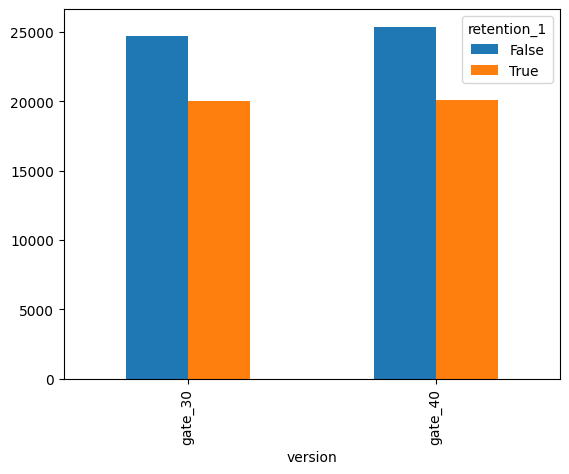

In [5]:
pd.crosstab(juegos['version'], juegos['retention_1']).plot(kind='bar');

In [19]:
# muestreo
index30=round(cross[True][0]/(cross[True][0]+cross[False][0]),2)
index40=round(cross[True][1]/(cross[True][1]+cross[False][1]),2)

In [20]:
index30, index40

(0.45, 0.44)

In [21]:
# calculo el tamaño del efecto. 
efecto=sms.proportion_effectsize(index30, index40)

In [22]:
efecto

0.02012246123322825

In [23]:
# tamaño de la muestra

n_requerido = sms.NormalIndPower().solve_power(efecto,     
                                               power=0.8,
                                               alpha=0.05
                                              )

n_requerido

38768.09024379976

Necesitamos **al menos 38769 observaciones para cada grupo**. 

Establecer el `poder estadístico` en 0.8 implica que si existe una diferencia significativa entre las tasas de conversión, tenemos un 80% de probabilidad de detectarla con este tamaño de la muestra.

In [33]:
#Muestreo

control1 = juegos[juegos['version']=='gate_30'].sample(n=38768, random_state=22)

tratamiento1 = juegos[juegos['version']=='gate_40'].sample(n=38768, random_state=22)

ab_test1=pd.concat([control, tratamiento], axis=0)

ab_test1.reset_index(drop=True, inplace=True)

ab_test1.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,7540471,gate_30,45,True,False
1,3589138,gate_30,21,True,False
2,3177668,gate_30,14,True,False
3,2133884,gate_30,26,False,False
4,492763,gate_30,39,True,True


In [35]:
ab_test1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77536 entries, 0 to 77535
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          77536 non-null  int64 
 1   version         77536 non-null  object
 2   sum_gamerounds  77536 non-null  int64 
 3   retention_1     77536 non-null  bool  
 4   retention_7     77536 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 1.9+ MB


In [37]:
ab_test1['version'].value_counts()

version
gate_30    38768
gate_40    38768
Name: count, dtype: int64

In [40]:
# testeo para retention_1

# seleccionar grupos OJO USA DF ab_test que ya trae el muestreo no el df original!!

control_res=ab_test1[ab_test1['version']=='gate_30']['retention_1']

trat_res=ab_test1[ab_test1['version']=='gate_40']['retention_1']


In [41]:
sum(control_res) #esto está contanto los trues dentro de la version control gate_30

17374

In [42]:
impresiones=[38768, 38768]  # count  , impresiones
    
conversiones=[control_res.sum(), trat_res.sum()]    # conversiones


z_score, p_value = proportions_ztest(conversiones, nobs=impresiones)

(control_a, trata_a), (control_b, trata_b) = proportion_confint(conversiones, 
                                                                nobs=impresiones,
                                                                alpha=0.05)

In [43]:
print(f'z-score: {z_score:.2f}')

print(f'p-valor: {p_value:.3f}')

print(f'intervalo conf 95% para grupo control: [{control_a:.3f}, {control_b:.3f}]')

print(f'intervalo conf 95% para grupo tratamiento: [{trata_a:.3f}, {trata_b:.3f}]')

z-score: 1.21
p-valor: 0.225
intervalo conf 95% para grupo control: [0.443, 0.453]
intervalo conf 95% para grupo tratamiento: [0.439, 0.449]


In [ ]:
# el p valor nos indica que no podemos rechazar H0 lo que significa que no hay diferencia considerable entre las dos versiones. Tendremos que hablar con el equipo de deiseño para que le echen un ojo.
# de igual manera el valor de confianza del grupo de tratamiento no incluye nuestro valor objetivo del 45% de conversión 

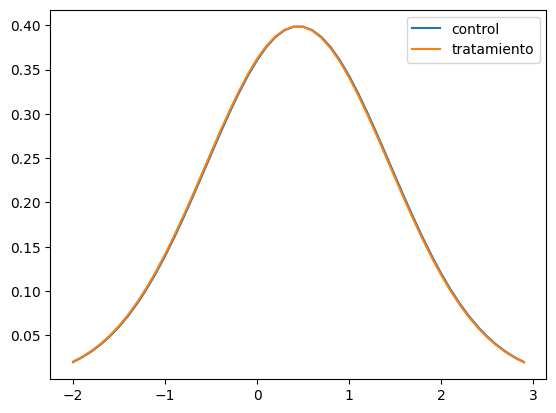

In [49]:
x=[i*.1 for i in range(-20,30)]  

# norm.pdf(x, media, std)

control=[norm.pdf(x, index30) for x in x] 

tratamiento=[norm.pdf(x, index40) for x in x] 

plt.plot(x, control)
plt.plot(x, tratamiento)
plt.legend(['control', 'tratamiento']);

# Bayes

Para el día 7

In [115]:
cross = pd.crosstab(juegos['version'], juegos['retention_7'])
cross

retention_7,False,True
version,,
gate_30,36198,8502
gate_40,37210,8279


In [116]:
imps_ctrl, convs_ctrl = cross[True][0]+cross[False][0], cross[True][0]
imps_test, convs_test = cross[False][1]+cross[True][1], cross[True][1]

In [117]:
CR_ctrl = convs_ctrl/imps_ctrl
CR_test = convs_test/imps_test

f'Tasas conversion: Control: {CR_ctrl}, Test: {CR_test}'

'Tasas conversion: Control: 0.19020134228187918, Test: 0.18200004396667327'

In [118]:
a_C, b_C = 1+convs_ctrl, 1+imps_ctrl-convs_ctrl

a_T, b_T = 1+convs_test, 1+imps_test-convs_test

beta_control = beta(a_C, b_C)

beta_test = beta(a_T, b_T)

In [119]:
beta_control.mean(), beta_test.mean()

(0.19021520289919913, 0.18201402475214878)

In [88]:
salto = (beta_test.mean() - beta_control.mean())/beta_control.mean()

salto

-0.04311526114658881

In [110]:
prob=calc_prob(beta_control, beta_test)  # esta funcion es la clave

prob

0.9992226613235504

In [111]:
'''El test disminuye la tasa de conversion en un {:2.2f}%, con una probabilidad del {:2.2f}%'''.format(salto*100, prob*100)



'El test disminuye la tasa de conversion en un -4.31%, con una probabilidad del 99.92%'

0.19020134228187918 0.18200004396667327


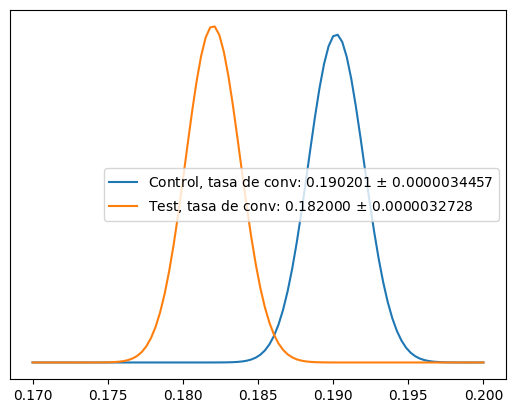

In [124]:
print (CR_ctrl, CR_test)

plot([beta_control, beta_test], ['Control', 'Test'], linf=0.17, lsup = 0.2)

Conclusion

In [ ]:
#podemos obersvar que el test disminuye la tasa de conversion en un -4.31%, con una probabilidad del 99.92%. Por lo tanto rechazamos H0. Y concluimos que en verdad la estrategia de recorrer el nivel de pago hacia delante no sirve
#Estaría interesante probar cambiarlo a 20 en vez de 30 pero como data analyst no es mi chamba dictar estrategias, eso le corresponde al product manager. 
#Humildemente, Anton